In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'serif'

In [24]:
nve_energy_eq = pd.read_csv('NSL_SIMULATOR/OUTPUT/EQUILIBRATION/NVE/potential_energy_1.1.dat', delim_whitespace=True) 
nvt_energy_eq = pd.read_csv('NSL_SIMULATOR/OUTPUT/EQUILIBRATION/NVT/potential_energy_1.1.dat', delim_whitespace=True)
nve_temp_eq = pd.read_csv('NSL_SIMULATOR/OUTPUT/EQUILIBRATION/NVE/temperature_2.0.dat', delim_whitespace=True)

In [25]:
nve_temp_eq

,#BLOCK:,ACTUAL_T:,T_AVE:,ERROR:
0,1,1.98000,1.98000,0.000000
1,2,1.97993,1.97996,0.000025
2,3,1.97972,1.97988,0.000070
3,4,1.97936,1.97975,0.000125
4,5,1.97886,1.97957,0.000188
...,...,...,...,...
9995,9996,1.12456,1.10896,0.000815
9996,9997,1.12276,1.10897,0.000815
9997,9998,1.12061,1.10897,0.000815
9998,9999,1.11814,1.10897,0.000815


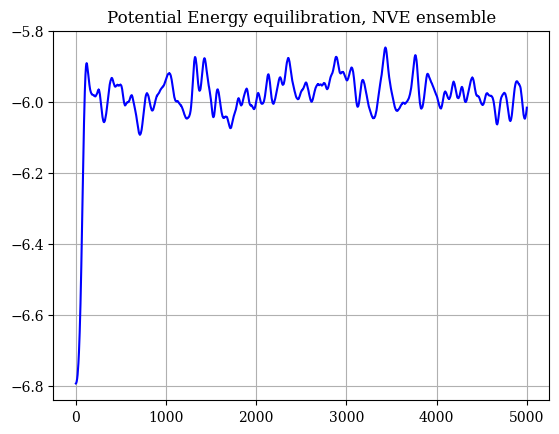

In [26]:
plt.plot(nve_energy_eq['#BLOCK:'], nve_energy_eq['ACTUAL_PE:'], color='blue', label='Potential Energy')
plt.title('Potential Energy equilibration, NVE ensemble')
plt.grid()
plt.show()

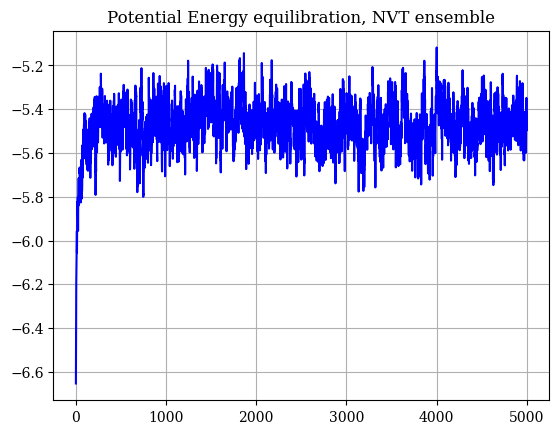

In [27]:
plt.plot(nvt_energy_eq['#BLOCK:'], nvt_energy_eq['ACTUAL_PE:'], color='blue', label='Potential Energy')
plt.title('Potential Energy equilibration, NVT ensemble')
plt.grid()
plt.show()

### temperatura NVE

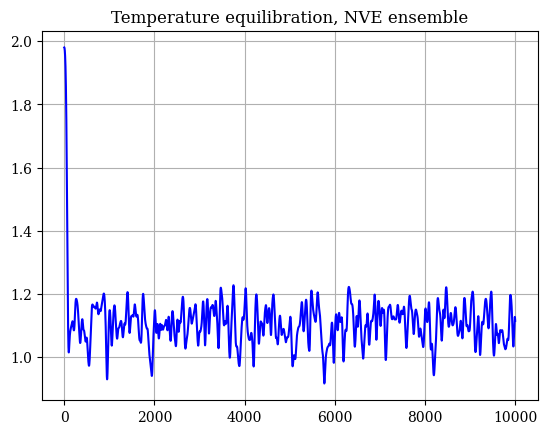

In [28]:
plt.plot(nve_temp_eq['#BLOCK:'], nve_temp_eq['ACTUAL_T:'], color='blue', label='Temperature')
plt.title('Temperature equilibration, NVE ensemble')
plt.grid()
plt.show()

In [29]:
nve_temp_eq['ACTUAL_T:'][-9000:].describe()

count    9000.000000
mean        1.103875
std         0.054608
min         0.917304
25%         1.068643
50%         1.107085
75%         1.142552
max         1.227960
Name: ACTUAL_T:, dtype: float64

In [30]:

@njit
def autocorrelation_numba(m, max_lag):
    """
    Calcola l'autocorrelazione χ(t) per t da 0 a max_lag secondo la formula:
      χ(t) = [1/(N−t) Σ m[i] m[i+t]
               − (1/(N−t) Σ m[i])·(1/(N−t) Σ m[i+t])]
             / [1/N Σ m[i]^2 − (1/N Σ m[i])^2]
    """
    N = m.size
    # Calcolo delle medie globali
    sum_all = 0.0
    sum_sq_all = 0.0
    for i in range(N):
        sum_all += m[i]
        sum_sq_all += m[i] * m[i]
    mean_all = sum_all / N
    mean_sq_all = sum_sq_all / N
    denom = mean_sq_all - mean_all * mean_all

    # Precomputo somme cumulative
    cumsum = np.empty(N+1, dtype=np.float64)
    cumsum[0] = 0.0
    for i in range(N):
        cumsum[i+1] = cumsum[i] + m[i]

    # Array risultato
    ac = np.empty(max_lag + 1, dtype=np.float64)

    # Calcolo per ogni lag
    for t in range(max_lag + 1):
        Nt = N - t
        sum0 = cumsum[Nt]               # Σ m[0:Nt]
        sum1 = cumsum[N] - cumsum[t]    # Σ m[t:N]
        # primo termine Σ m[i]·m[i+t] / Nt
        s_prod = 0.0
        for i in range(Nt):
            s_prod += m[i] * m[i + t]
        first = s_prod / Nt
        correction = (sum0 * sum1) / (Nt * Nt)
        ac[t] = (first - correction) / denom if denom != 0.0 else 0.0

    return ac


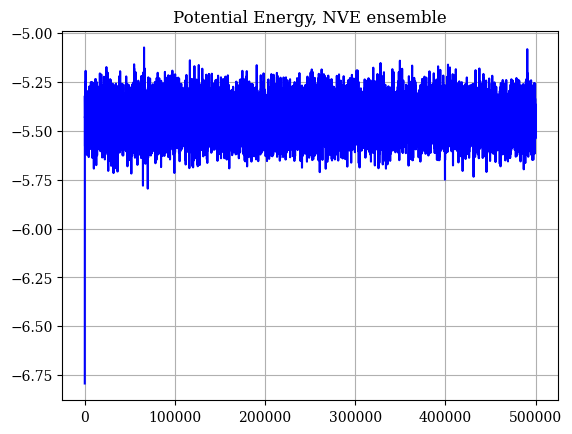

In [31]:
nve_energy_ist = pd.read_csv('NSL_SIMULATOR/OUTPUT/NVE/potential_energy_2.0.dat', delim_whitespace=True)
nvt_energy_ist = pd.read_csv('NSL_SIMULATOR/OUTPUT/NVT/potential_energy_1.1.dat', delim_whitespace=True)
plt.plot(nve_energy_ist['#BLOCK:'], nve_energy_ist['ACTUAL_PE:'], color='blue', label='Potential Energy')
plt.title('Potential Energy, NVE ensemble')

plt.grid()
plt.show()

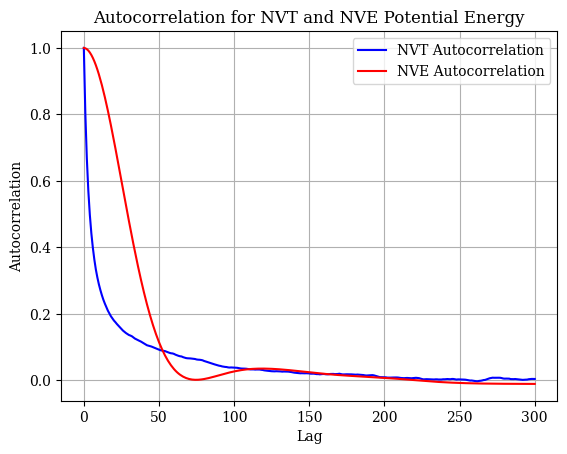

In [32]:
# Calcolo dell'autocorrelazione per NVE
max_lag = 300
series_nve = nve_energy_ist['ACTUAL_PE:'].values.astype(np.float64)
acf_values_nve = autocorrelation_numba(series_nve, max_lag)
series_nvt = nvt_energy_ist['ACTUAL_PE:'].values.astype(np.float64)
acf_values_nvt = autocorrelation_numba(series_nvt, max_lag)

# Plot dei due grafici insieme
plt.plot(range(max_lag + 1), acf_values_nvt, color='blue', label='NVT Autocorrelation')
plt.plot(range(max_lag + 1), acf_values_nve, color='red', label='NVE Autocorrelation')
plt.title('Autocorrelation for NVT and NVE Potential Energy')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid()
plt.show()

